# SIADS 521, Assignment 4

By: Grant Jason

## Rule et al's computational narrative rules used

### 1. Tell a story
Through the notebook, I attempt to use both markdown cells and comments inside code cells to help the viewer understand what I am doing and the story I am trying to tell with the data

### 2. Document the process, not the results
Similar to above, I try to ensure the notebook is very linear and clearly commented throughout

### 3. Use cell divisions to make steps clear
I try to clearly break up each major step in the workflow into its own cell

### 4. Modularize code
I contain each chart into its own function so when I need to generate a dashoboard using them later, I just call the function instead of re-writing the code

### 6. Use version control
This notebook was built using a private git repository on my github profile: https://github.com/grantajason

In [15]:
# import statements

import pandas as pd                                 # Data manipulation
import numpy as np                                  # For any stats or math needed
import matplotlib.pyplot as plt                     # General plotting and formatting
import seaborn as sns                               # More advanced charting
import plotly.express as px                         # New graphing library I wanted to try - I like their 2D Histograms
import ipywidgets as widgets                        # For interaction
from matplotlib.lines import Line2D                 # For legends
from matplotlib import style                        # For setting overall style
from IPython.display import display, clear_output   # For dashboarding
from ipywidgets import interact, interactive        # For interaction

## Data Preparation
To start, lets bring in the inital data set and perform some general cleansings that will likely be applicable to all charts. Any chart specific cleansing or transformations I will do within the function that is used to create each chart.

In [16]:
# bring in strava data

strava = pd.read_csv('~/Downloads/strava.csv')

# convert timestamp to datetime object for easier manipulation
strava['timestamp'] = pd.to_datetime(strava['timestamp'])
strava['month_name'] = strava['timestamp'].dt.month_name()
strava['date'] = strava['timestamp'].dt.date

# calculate actual degrees in case I use lat/lon
strava['lat_deg'] = strava['position_lat'] * (180/2**31)
strava['lon_deg'] = strava['position_long'] * (180/2**31)

strava.head()

,Air Power,Cadence,Form Power,Ground Time,Leg Spring Stiffness,Power,Vertical Oscillation,altitude,cadence,datafile,...,position_long,speed,timestamp,unknown_87,unknown_88,unknown_90,month_name,date,lat_deg,lon_deg
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,activities/2675855419.fit.gz,...,NaN,0.0,2019-07-08 21:04:03,0.0,300.0,NaN,July,2019-07-08,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,activities/2675855419.fit.gz,...,NaN,0.0,2019-07-08 21:04:04,0.0,300.0,NaN,July,2019-07-08,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.0,activities/2675855419.fit.gz,...,NaN,1316.0,2019-07-08 21:04:07,0.0,300.0,NaN,July,2019-07-08,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3747.0,77.0,activities/2675855419.fit.gz,...,-999063637.0,1866.0,2019-07-08 21:04:14,0.0,100.0,NaN,July,2019-07-08,42.281006,-83.740547
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3798.0,77.0,activities/2675855419.fit.gz,...,-999064534.0,1894.0,2019-07-08 21:04:15,0.0,100.0,NaN,July,2019-07-08,42.281043,-83.740622


## Chart #1
### How much did Prof Brooks' cardio health increase over the summer?
The first thing I want to do to understand how much Prof Brooks' cardio health improved over the summer. To do this, I want to look at the distribution of heart rates over the time periods available in the data set. I decided to use a violin plot to show this distribution, with the X Axis being the month and the Y axis being the heart rate distribution.

In [17]:
def cardio_health_violin(ax):
    # create copy of initial data set to avoid errors later
    cardio = strava.copy()

    violin = sns.violinplot(x=strava['month_name'], y=strava['heart_rate'], ax=ax)

    ax.set_title('Heart Rate Distribution by Month', pad=20, fontweight='bold')
    ax.set_xlabel('Month', labelpad=20, fontsize=12)
    ax.set_ylabel('Heart Rate in BPM', labelpad=20, fontsize=12)

Hmm this chart has some interesting variation. Why was July the lowest? Why does October have the highest concentration of BPM around 140? Lets dig in further.

## Chart #2
### Plotting heart rate against activity

I notice we have a 'speed' column. I'm going to do some analysis to see if we can identify which acitivity Prof Brooks did not a given day. Presumably an activity like running would have a much lower average speed than an activity like biking. Perhaps we can use this information to identify which activity Prof Brooks was doing on a given day, and see if one activity type leads to a higher heart rate than others.


In [18]:
speed = strava.groupby('date').agg({'enhanced_speed': 'mean', 'heart_rate': 'mean'}).reset_index()

Okay! So looking at the data this way, we see some days the average speed in m/s hovers around 2 which we can assume is Prof Brooks' running pace, and others hovers between 5-7 m/s which might be his biking pace. Lets use ~3 m/s as the cutoff to help us distinguish the activity on a given day between running a biking. Lets then plot these against eachother to see if one activity lead Prof Brooks' heart rate to be higher than the other.

I'm going to use color to identify which month a data point occurred in, and shape to identify which activity type it was.

In [19]:
def running_or_biking(speed):
    if speed >= 3:
        return 'Biking'
    else:
        return 'Running'
    
speed['activity'] = speed['enhanced_speed'].apply(running_or_biking)
speed['month'] = pd.to_datetime(speed['date']).dt.month_name()

In [20]:
def activity_scatter(ax):
    activity = speed.copy()

    # identify mappings for each categorical mark
    color_map = {'July': 'tab:blue', 'August': 'tab:orange', 'September': 'tab:green', 'October': 'tab:red'}
    marker_map = {'Running': '^', 'Biking': 'o'}

    # generate scatter given two categorical encodings
    for i in range(len(activity)):
        ax.scatter(x=activity['enhanced_speed'].iloc[i],
                   y=activity['heart_rate'].iloc[i],
                   c=color_map[activity['month'].iloc[i]],
                   marker=marker_map[activity['activity'].iloc[i]])

    # create legend handle
    legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=month)
                      for month, color in color_map.items()]

    ax.legend(handles=legend_handles, title='Month', prop={'size': 8})
    ax.set_title('Speed v Heart Rate', pad=20, fontweight='bold')
    ax.set_xlim(0,10)
    ax.set_xlabel('Speed in m/s', labelpad=20, fontsize=12)
    ax.set_ylabel('Heart Rate in BPM', labelpad=20, fontsize=12)

Okay, so we learned a few new things from this. First, it appears Prof Brooks became interested in biking around September. The other interesting thing is his heart rate was much higher while running on average in August than it was July.

I'm very interested in why there is such a difference between July and August. Lets take a look next at some other things that might impact heart rate in the data, and figure out why this might have been.

## Chart #4
### How did altitude impact heart rate zones?

To aid in this analysis, I am going to group what "Zone" a heart rate reading was in. Read more about heart rate zones here: https://health.clevelandclinic.org/exercise-heart-rate-zones-explained

To caluclate these zones, you first calculate your maximum heart rate. The formula for this is 220 - Current Age. Although the data is specific to Professor Brooks, I do not know his age! I'm going to add some interactivity so Professor Brooks can enter his current age.

Likewise, you then need the user's resting heart rate. This is to calculate the Heart Rate Reserve, which is Max Heart Rate - Resting Heart Rate. You then multiple each zone's relative intensity by percent, and add it back to the resting heart rate. Lets start to build this out.

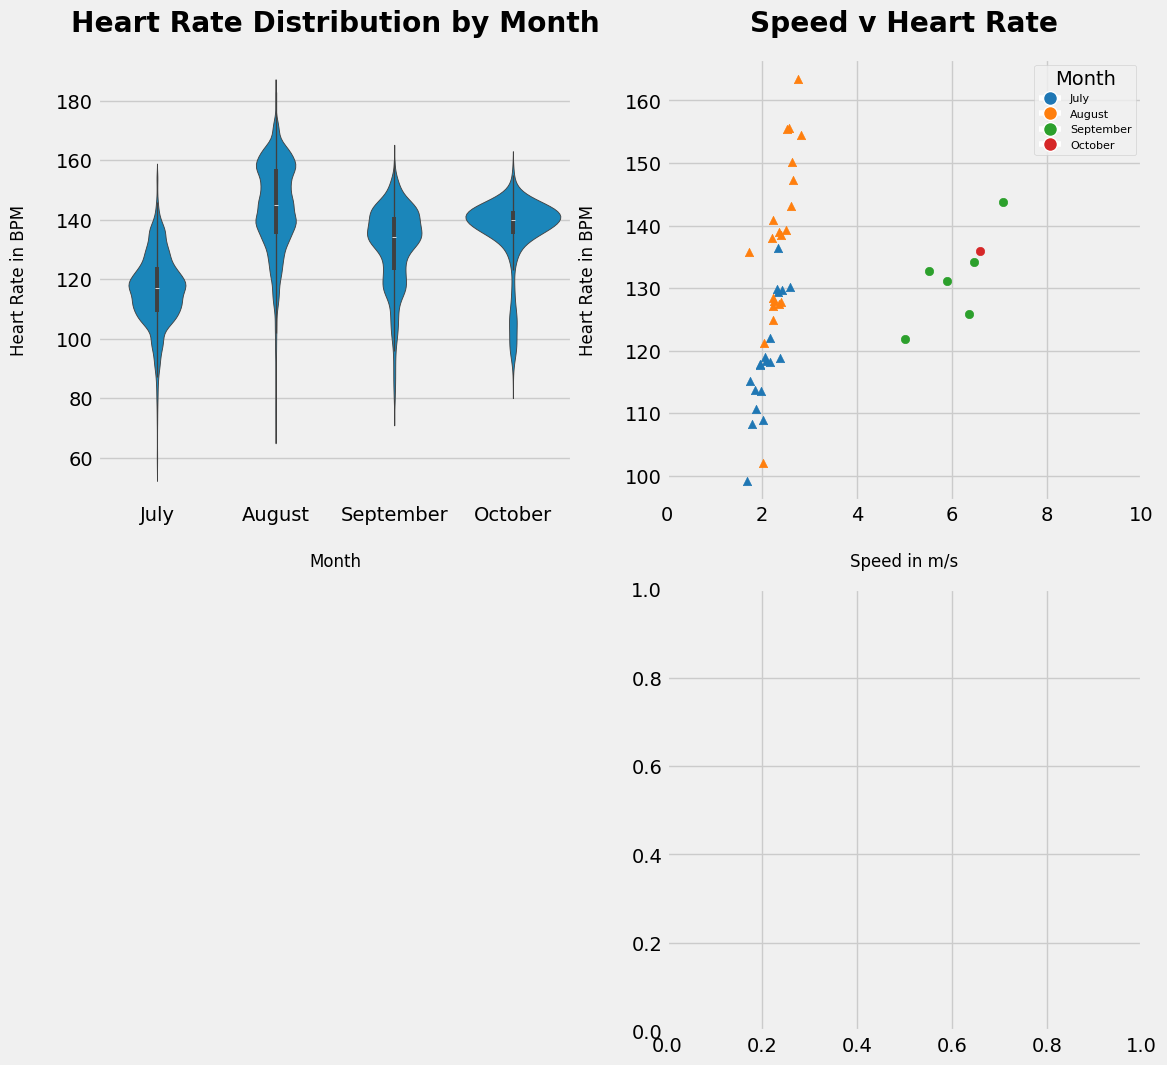

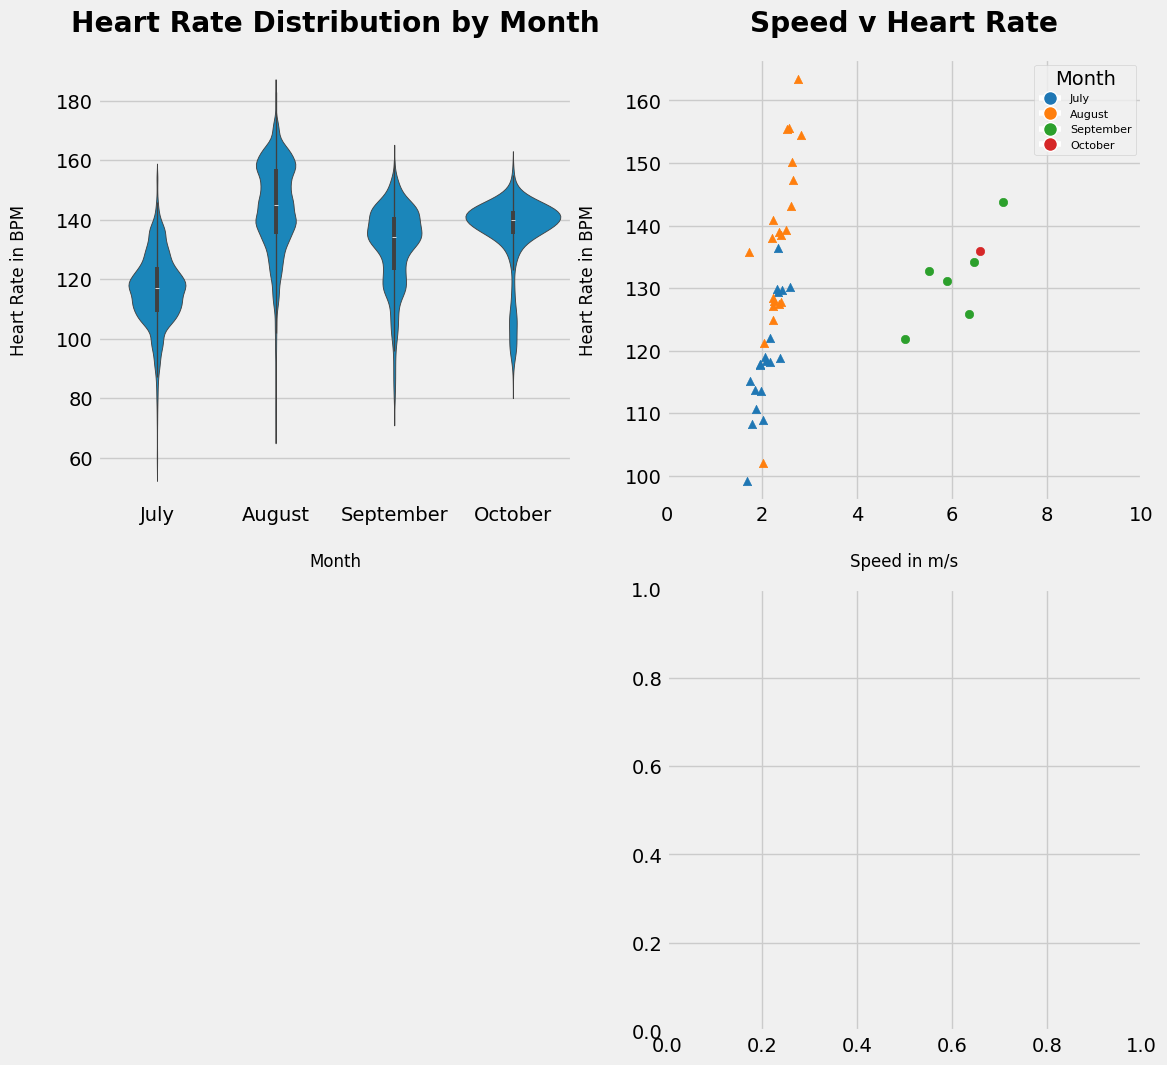

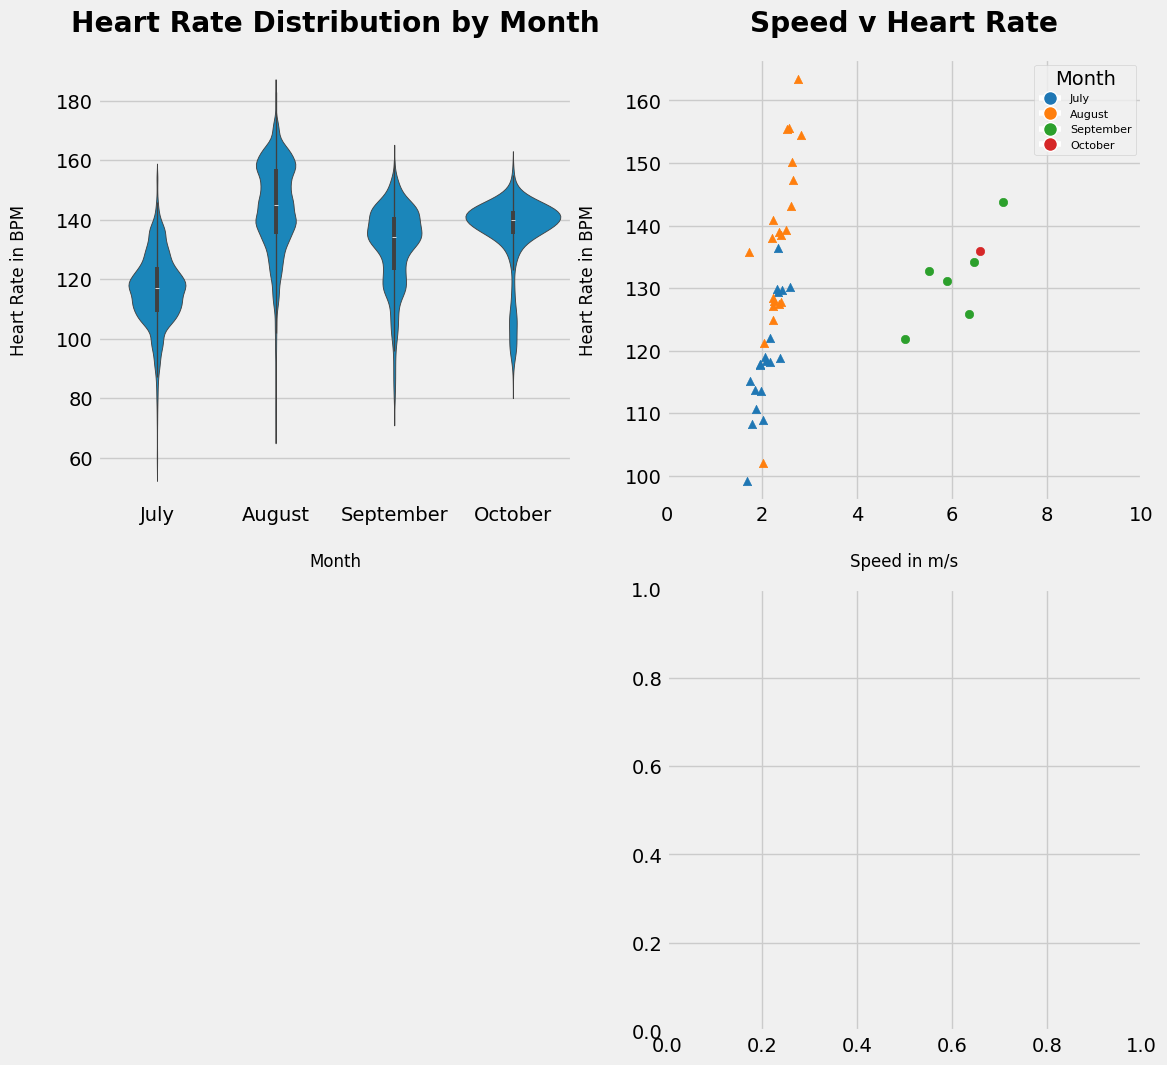

In [21]:
# Create Age Selector
select_age = widgets.IntSlider(
    value=40,
    min=18,
    max=100,
    step=1,
    description='Select Current Age:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

# Create Resting Heart Rate Selector
select_resting_hr = widgets.IntSlider(
    value=75,
    min=40,
    max=100,
    step=1,
    description='Select Resting Heart Rate:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

months = strava['month_name'].unique()

# Month Selector
select_month = widgets.Dropdown(
    options=months,
    description='Month:',
    value='July',
    disabled=False,
    layout=widgets.Layout(width='20%'),
    style={'description_width': 'initial'}
)

In [22]:
def calculate_hr_zones(heart_rate, age, resting_hr):
    max_hr = 220 - age
    hr_reserve = max_hr - resting_hr

    if heart_rate < (resting_hr + (hr_reserve * 0.5)):
        return "Resting"
    elif resting_hr + (hr_reserve * 0.5) <= heart_rate < (resting_hr + (hr_reserve * 0.6)): # fixed logic
        return "Zone 1"
    elif resting_hr + (hr_reserve * 0.6) <= heart_rate < (resting_hr + (hr_reserve * 0.7)): # fixed logic
        return "Zone 2"
    elif resting_hr + (hr_reserve * 0.7) <= heart_rate < (resting_hr + (hr_reserve * 0.8)): # fixed logic
        return "Zone 3"
    elif resting_hr + (hr_reserve * 0.8) <= heart_rate < (resting_hr + (hr_reserve * 0.9)): # fixed logic
        return "Zone 4"
    elif heart_rate >= (resting_hr + (hr_reserve * 0.9)):
        return "Zone 5"
    else:
        return None

In [ ]:
def activity_hr_heatmap(ax, age, resting_hr, month):
    hr_data = strava.copy()
    hr_data['zone'] = hr_data['heart_rate'].apply(lambda hr: calculate_hr_zones(hr, age, resting_hr))
    hr_data = hr_data[hr_data['month_name'] == month]

    fig = px.density_heatmap(hr_data, x='zone', y='enhanced_altitude')

    for trace in fig.data:
      ax.add_trace(trace)

    # finish implementing this function; need to ensure it works and add formatting


## Create Dashboard
### Bringing all the charts into one view!
Alright! Now that I feel like we have a good set of charts, lets assemble them all into one view and render the dashboard.

interactive(children=(IntSlider(value=75, continuous_update=False, description='Select Resting Heart Rate:', m…

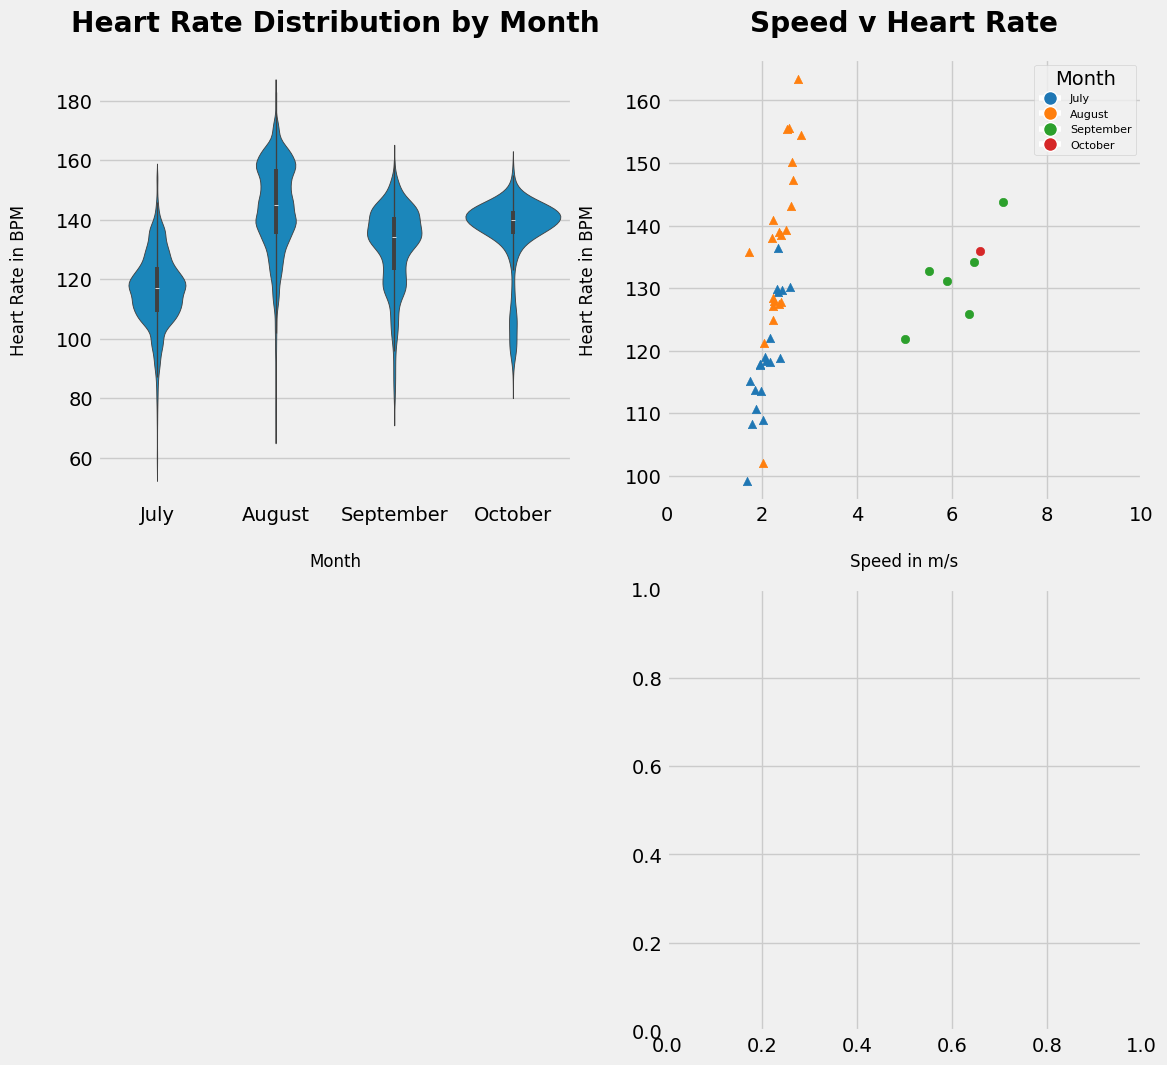

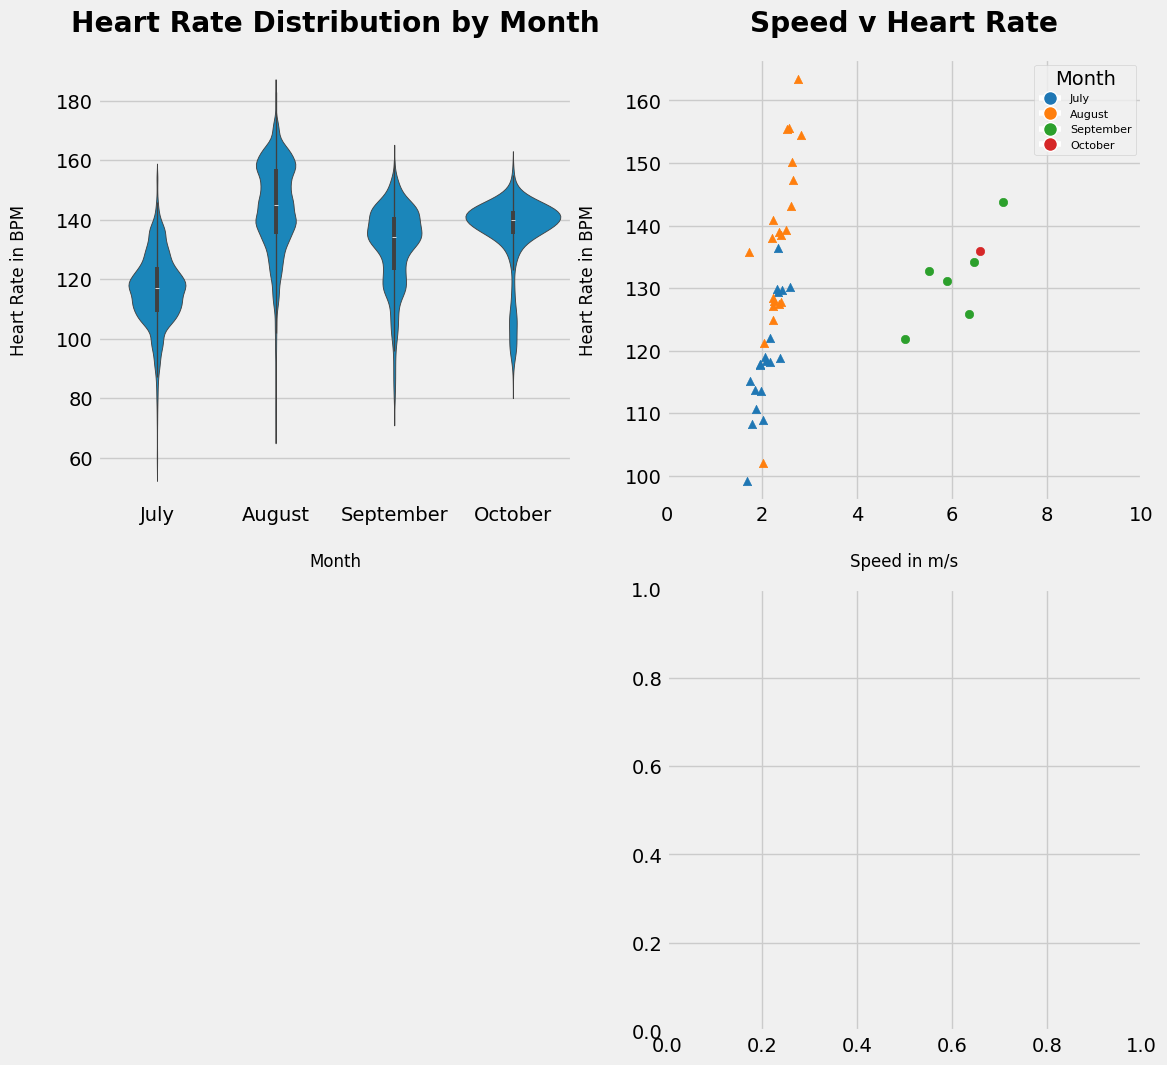

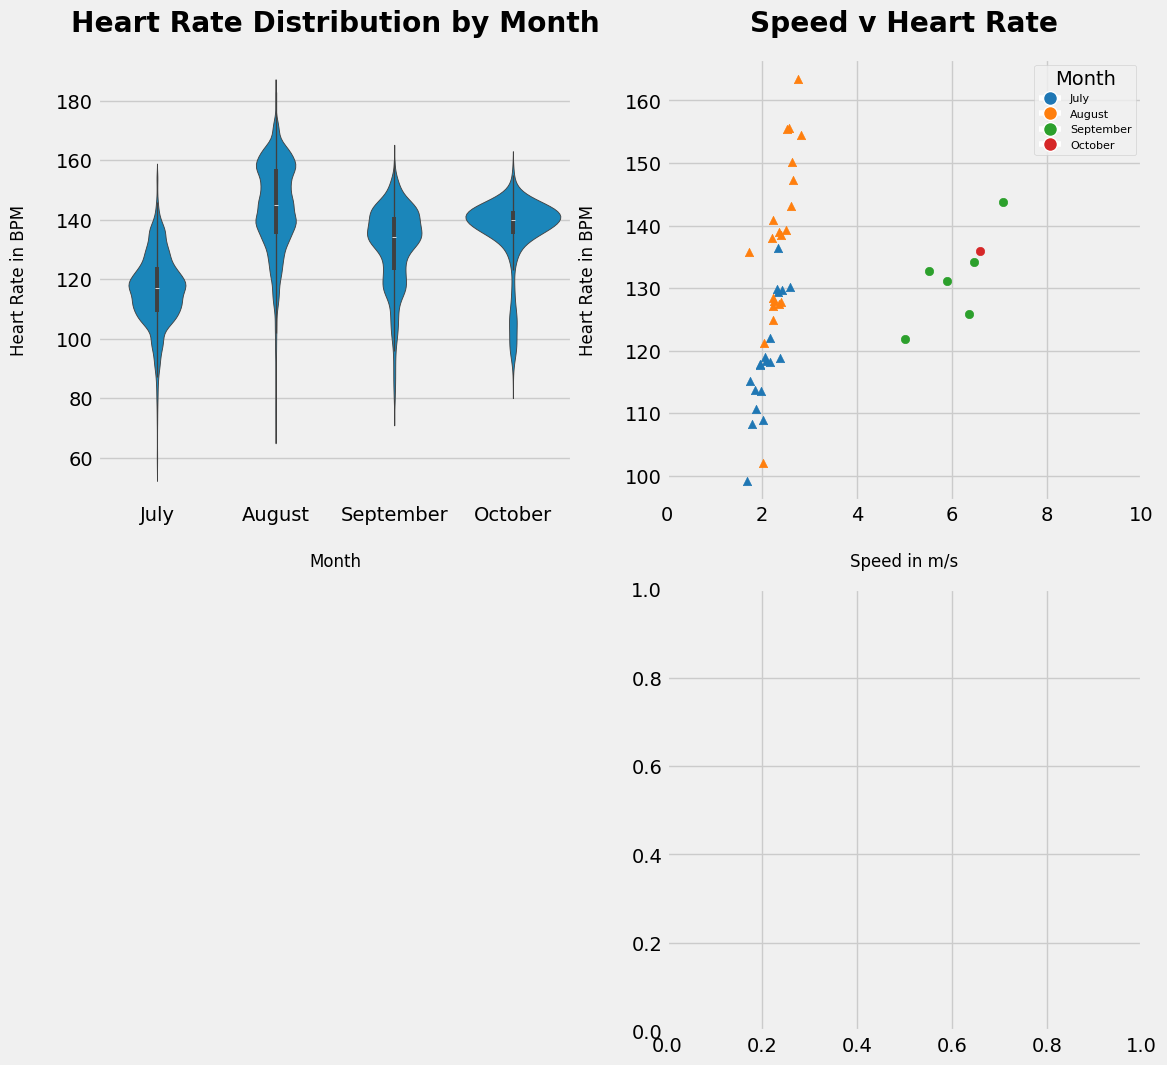

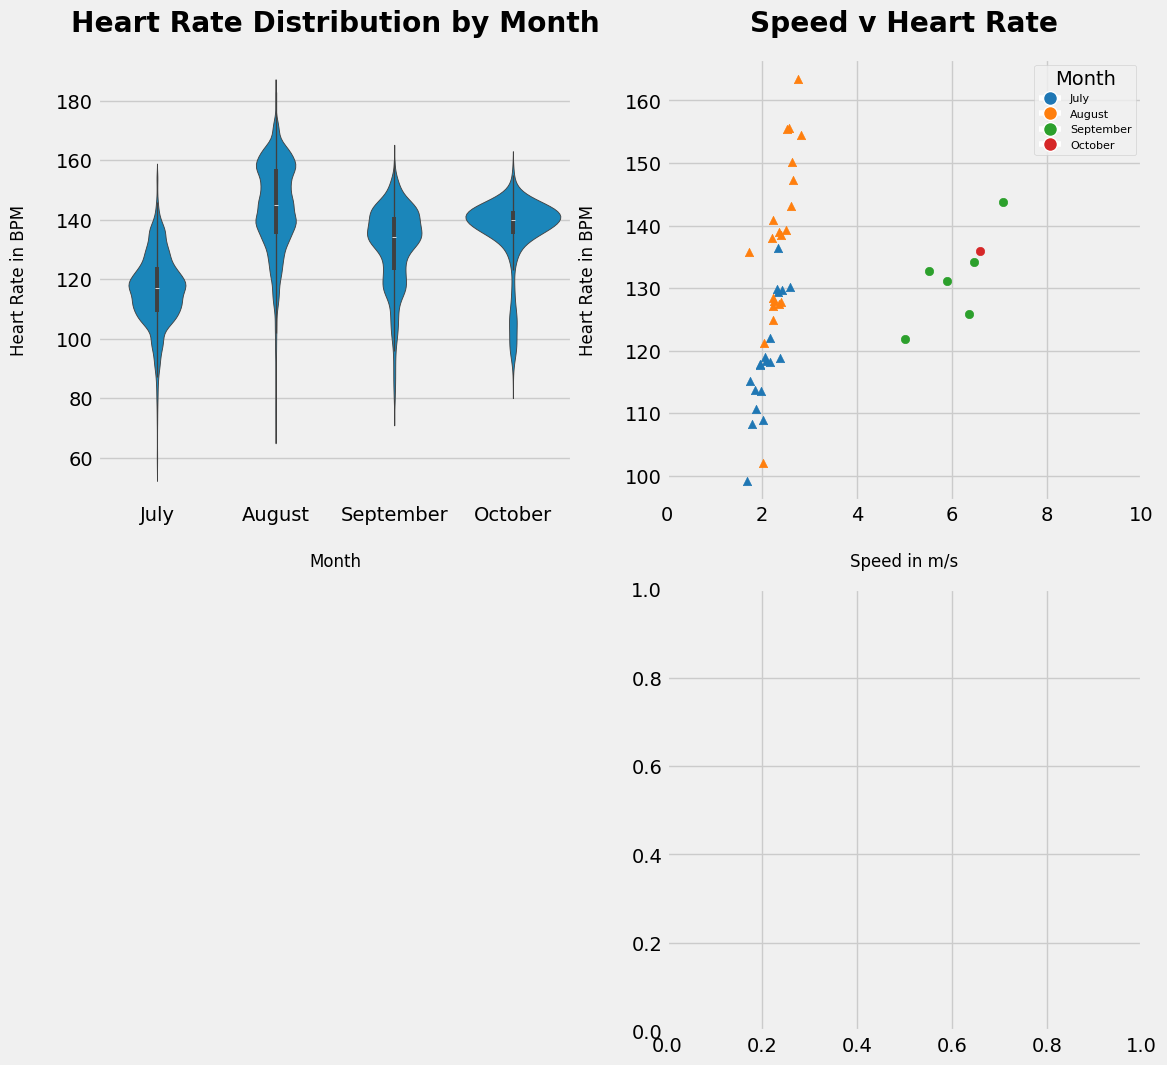

In [27]:
def create_dashboard(resting_hr, age, month):

    clear_output(wait=True)
    plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(12,12))
    gs = fig.add_gridspec(2,2)

    ax1 = fig.add_subplot(gs[0, 0])
    fig.sca(ax1)
    cardio_health_violin(ax1)

    ax2 = fig.add_subplot(gs[0, 1])
    fig.sca(ax2)
    activity_scatter(ax2)

    # figure out how to display a plotly graph using gridspec add_subplot
    ax4 = fig.add_subplot(gs[1, 1])
    fig.sca(ax4)
    activity_hr_heatmap(ax4, age=age, resting_hr=resting_hr, month=month)


dashboard = interactive(create_dashboard, resting_hr=select_resting_hr, age=select_age, month=select_month)
dashboard